# 

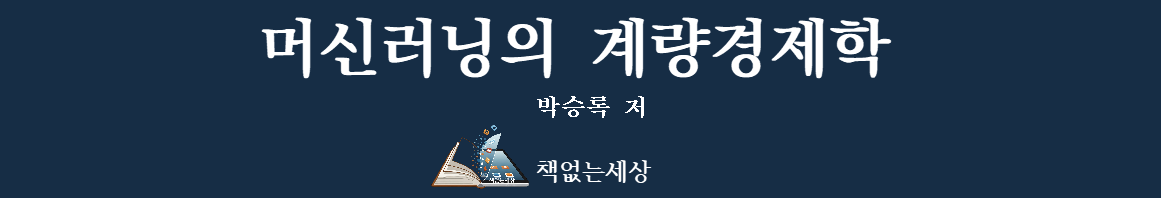

# Part 8: 인과추론

## Chapter 2. Chapter 2: 인과추론의 분석 절차: DoWhy 활용

In [1]:
# 작업공간(working directory)지정  
import os  
os.chdir("X:/Econometrics_with_ML")
# 현재 작업공간(working directory)확인  
os.getcwd() 

'X:\\Econometrics_with_ML'

In [6]:
# 본서에서 사용되는 모든 Library 불러오기 
exec(open('Functions/Machine Learning_Econometrics_Lib.py').read())

### 7. DoWhy를 활용한 인과추론 사례 연구

In [9]:
import pandas as pd
import numpy as np
import dowhy
import pydot
import pygraphviz
from dowhy import CausalModel

import warnings
warnings.filterwarnings("ignore")

In [10]:
# 데이터 불러오기
df=pd.read_csv('Data/Salary_Data.csv')
df.info()

# 칼럼명의 공백을 _로 바꿈
df.rename(columns=lambda x:x.replace(' ', '_'),inplace=True)

# 숫자 변수의 누락치를 평균으로 채움
numeric = ['Age', 'Years_of_Experience', 'Salary']
for col in numeric:
    df[col].fillna(df[col].mean(), inplace=True)

# 카테고리 변수의 누락치를 최빈수로 채움 
categorical = ['Gender', 'Education_Level']
for col in categorical:
    mode_val = df[col].mode()[0] 
    df[col].fillna(mode_val, inplace=True)

# 교육수준의 PhD=1, 나머지는 0으로 바꿈
df['Education_Level'] = np.where(df['Education_Level'] == "PhD", 1, 0)

# 성별의 Male=1, Female=0로 바꿈
df['Gender'] = np.where(df['Gender'] == "Male", 1, 0)

# 모형에 포함시킬 변수만 선택
df=df[['Age', 'Gender', 'Education_Level', 'Years_of_Experience', 'Salary']]
print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   int64  
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 314.3+ KB
                      count           mean           std    min      25%  \
Age                  6702.0      33.620859      7.614633   21.0     28.0   
Gender               6702.0       0.548195      0.497709    0.0      0.0   
Education_Level      6702.0       0.204118      0.403086    0.0      0.0   
Years_of_Experience  6702.0       8.094687      6.058551    0.0      3.0   
Salary               6702.0  115326.964771  52774.

### 다. DoWhy를 이용한 인과추론
#### 1) 인과관계 모형 설정

In [11]:
# 인과 그래프 
causal_graph = """
                digraph {Age; Gender; Education_Level; Years_of_Experience; Salary;
                Gender -> Education_Level -> Salary;
                Gender -> Salary;
                Age -> Years_of_Experience -> Salary;
                Age -> Education_Level;
                Age -> Salary;
                Gender->Salary;
                       }"""

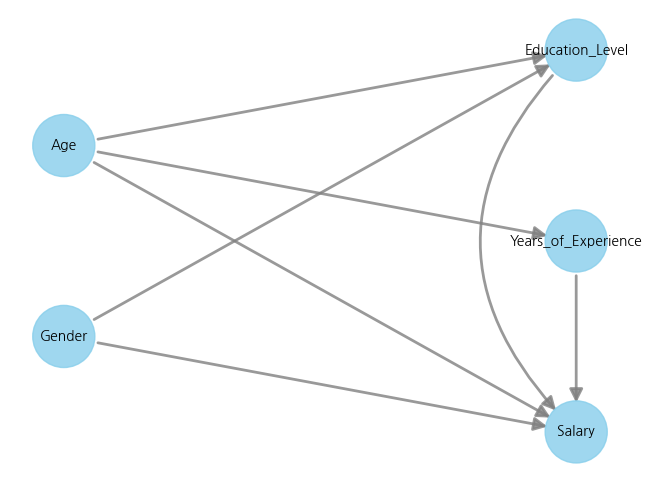

In [12]:
# 모형설정
model= CausalModel(data = df,
                   graph=causal_graph.replace("\n", " "),
                   treatment='Education_Level',
                   outcome='Salary')
model.view_model()

#### 2) 모형의 식별

In [14]:
# 식별
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
──────────────────(E[Salary|Gender,Age])
d[Education_Level]                      
Estimand assumption 1, Unconfoundedness: If U→{Education_Level} and U→Salary then P(Salary|Education_Level,Gender,Age,U) = P(Salary|Education_Level,Gender,Age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
        d                               
──────────────────(E[Salary|Gender,Age])
d[Education_Level]                      
Estimand assumption 1, Unconfoundedness: If U→{Education_Level} and U→Salary then P(Salary|Education_Level,Gender,Age,U) = P(Salary|Education_Level,Gender,Age)



#### 3) 모형의 추정

In [15]:
# 추정
estimate= model.estimate_effect(
             identified_estimand=estimand,
             method_name='backdoor.linear_regression',
             confidence_intervals=True,
             test_significance=True
            )
print(f'Estimate of causal effect: {estimate}')

Estimate of causal effect: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
──────────────────(E[Salary|Gender,Age])
d[Education_Level]                      
Estimand assumption 1, Unconfoundedness: If U→{Education_Level} and U→Salary then P(Salary|Education_Level,Gender,Age,U) = P(Salary|Education_Level,Gender,Age)

## Realized estimand
b: Salary~Education_Level+Gender+Age+Education_Level*Years_of_Experience
Target units: 

## Estimate
Mean value: 29131.80081382199
p-value: [3.7653675e-59]
95.0% confidence interval: (25595.527921558445, 32527.822215158405)
### Conditional Estimates
__categorical__Years_of_Experience
(-0.001, 3.0]    41962.288268
(3.0, 5.0]       36717.401160
(5.0, 8.0]       31421.821119
(8.0, 13.0]      23473.231763
(13.0, 34.0]      8802.870153
dtype: float64


In [16]:
# PCM 사용한 추정
estimate2= model.estimate_effect(
             identified_estimand=estimand,
             method_name='backdoor.propensity_score_matching',
            )
print(f'Estimate of causal effect: {estimate2}')


Estimate of causal effect: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
──────────────────(E[Salary|Gender,Age])
d[Education_Level]                      
Estimand assumption 1, Unconfoundedness: If U→{Education_Level} and U→Salary then P(Salary|Education_Level,Gender,Age,U) = P(Salary|Education_Level,Gender,Age)

## Realized estimand
b: Salary~Education_Level+Gender+Age
Target units: ate

## Estimate
Mean value: 24604.596255697918



#### 4) 반증

In [17]:
# 반증(3가지 방법)
refutel_common_cause=model.refute_estimate(estimand, estimate,"random_common_cause")
print(refutel_common_cause)

refutel_common_cause=model.refute_estimate(estimand, estimate,"data_subset_refuter")
print(refutel_common_cause)

refutel_common_cause=model.refute_estimate(estimand, estimate,"placebo_treatment_refuter")
print(refutel_common_cause)

Refute: Add a random common cause
Estimated effect:29131.80081382199
New effect:29131.58879249694
p value:0.98

Refute: Use a subset of data
Estimated effect:29131.80081382199
New effect:29141.019121733025
p value:0.8999999999999999

Refute: Use a Placebo Treatment
Estimated effect:29131.80081382199
New effect:-132.9426715545685
p value:0.9



### 라. DoWhy를 이용한 반사실적 결과 분석

In [10]:
# 반사실적 결과 계산
counterfactual = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.linear_regression",
    target_units=lambda df: df[df['Education_Level'] == 0]
)
print("Counterfactual Outcome for untreated units: ", counterfactual.value)

Counterfactual Outcome for untreated units:  29131.80081382292


### 마. DoWhy를 이용한 특정 변수 하위그룹 분석

In [19]:
# 추정된 효과를 다양한 하위 그룹으로 나누어 분석
subgroups = df['Years_of_Experience'].quantile([0.20, 0.40, 0.6, 0.8]).values

for threshold in subgroups:
    subgroup_data = df[df['Years_of_Experience'] <= threshold]
    subgroup_model = CausalModel(
        data=subgroup_data,
        treatment='Education_Level',
        outcome='Salary',
        graph=causal_graph.replace("\n", " "),
    )
    subgroup_estimand = subgroup_model.identify_effect()
    subgroup_estimate = subgroup_model.estimate_effect(
        subgroup_estimand,
        method_name="backdoor.propensity_score_matching"
    )
    print(f"Causal Effect for confounder <= {threshold}: ", subgroup_estimate.value)

Causal Effect for confounder <= 3.0:  55361.331034482755
Causal Effect for confounder <= 5.0:  30508.34354953671
Causal Effect for confounder <= 8.0:  9649.704540372335
Causal Effect for confounder <= 13.0:  26377.437473374062


### 사. 변화된 조건 하에서의 예측 및 'What-if' 질문에 대한 답변

In [20]:
# What-if 분석 수행: 특정 처리 여부 변경
new_df = df.copy()
new_df['Education_Level'] = 1 

# 인과 효과 추정 
# 모형설정
new_model = CausalModel(
    data=new_df,
    graph=causal_graph.replace("\n", " "),
    treatment='Education_Level',
    outcome='Salary',
                        )
# 모형식별
new_estimand = new_model.identify_effect()

# 모형추정
new_estimate = new_model.estimate_effect(new_estimand, method_name="backdoor.linear_regression")
print("Predicted Outcome under treatment for all: ", new_estimate.value)

Predicted Outcome under treatment for all:  123878.00015970855
